In [ ]:
import numpy as np
import tensorflow as tf
import os
import cv2
from skimage.util import view_as_blocks
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**FUNCTIONS**

In [ ]:
def load_tf_model(model_dir):
    """
    Load a TensorFlow model from a directory.

    Args:
        model_dir: The directory containing the model.
    """
    return tf.keras.models.load_model(model_dir)

In [ ]:
def transmit_patches(patches, model):
    """
    Passes the patches through encoder, channel, and all decoders available in the model

    Args:
        patches (np.ndarray): The patches to be transmitted. Shape: (n_patches, H, W, 3)
        model (tf.keras.Model): The model.

    Returns:
        np.ndarray: The outputs of all decoders in the model. Shape: (n_decoders, n_patches, H, W, 3)
    """

    output = np.array(model(patches))
    return output

In [ ]:
# Function to calculate MSE
def calculate_mse(original, reconstructed):
    err = np.sum((original.astype("float") - reconstructed.astype("float")) ** 2)
    err /= float(original.shape[0] * original.shape[1])
    return err

In [ ]:
# Function to calculate PSNR
def calculate_psnr(original, reconstructed):
    mse = calculate_mse(original, reconstructed)

    if mse == 0:
        return float('inf')

    max_pixel = 255.0

    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))

    return psnr

In [ ]:
def divide_image_into_patches(image, patch_size):
    rows, cols, _ = image.shape
    patches = []

    for r in range(0, rows, patch_size):
        for c in range(0, cols, patch_size):
            patch = image[r:r+patch_size, c:c+patch_size]
            patches.append(patch)

    return np.array(patches)

In [ ]:
# Function to calculate the psnr values by patch and decoder
def calculate_psnr_values_by_patch(patches, transmitted_patches):
  # Initialize a dictionary to store PSNR values by patch
  psnr_values_by_patch = {}

  # Iterate over each patch
  for patch_idx in range(len(patches)):
      # List to store PSNR values for the current patch from all decoders
      patch_psnr_values = []

      # Iterate over each decoder
      for decoder_idx in range(len(transmitted_patches)):
          # Original patch
          original = patches[patch_idx]

          # Reconstructed patch from the current decoder
          reconstructed = transmitted_patches[decoder_idx][patch_idx]

          # Convert the patches from [0, 1] to [0, 255] range for PSNR calculation
          original_255 = (original * 255).astype(np.uint8)
          reconstructed_255 = (reconstructed * 255).astype(np.uint8)

          # Calculate PSNR
          psnr = calculate_psnr(original_255, reconstructed_255)
          patch_psnr_values.append(psnr)

      # Store the PSNR values for the current patch
      psnr_values_by_patch[patch_idx] = patch_psnr_values

  return psnr_values_by_patch

In [ ]:
# Function to reconstruct the image from the patches
def reconstruct_image_from_patches(patches, decoder_choices, original_image_shape, patch_size):
    # Calculate the padded image shape based on the patch size
    padded_height = (original_image_shape[0] + patch_size - 1) // patch_size * patch_size
    padded_width = (original_image_shape[1] + patch_size - 1) // patch_size * patch_size

    reconstructed_image = np.zeros((padded_height, padded_width, 3), dtype=np.uint8)
    n_cols = padded_width // patch_size

    for idx, choice in enumerate(decoder_choices):
        row = (idx // n_cols) * patch_size
        col = (idx % n_cols) * patch_size

        # Extract the reconstructed patch from the selected decoder
        reconstructed_patch = patches[choice-1][idx]

        # Scale the patch to the [0, 255] range and assign it to the reconstructed image
        reconstructed_image[row:row + patch_size, col:col + patch_size] = (reconstructed_patch * 255).astype(np.uint8)

    # Crop the reconstructed image to the original image size
    reconstructed_image_cropped = reconstructed_image[:original_image_shape[0], :original_image_shape[1]]

    return reconstructed_image_cropped

In [ ]:
def transform_image(image, patch_size):
    full_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Calculate the dimensions for padding to make it divisible by patch_size
    padded_height = (full_image.shape[0] + patch_size - 1) // patch_size * patch_size
    padded_width = (full_image.shape[1] + patch_size - 1) // patch_size * patch_size

    # Pad the image with zeros to meet the requirements
    padded_image = np.zeros((padded_height, padded_width, 3), dtype=np.uint8)
    padded_image[:full_image.shape[0], :full_image.shape[1], :] = full_image

    # Scale the image to the [0, 1] range
    padded_image = (padded_image / 255)

    return padded_image

**METHOD 1 (THRESHOLD)**

In [ ]:
# Function to select the best decoder for each patch based on PSNR
def select_decoder_m1(psnr_values_by_patch, psnr_threshold):
    decoder_choice_for_patches = []

    for psnr_values in psnr_values_by_patch.values():
        # Initialize the best decoder index to None
        best_decoder_idx = None

        # Iterate through each decoder's PSNR value for the current patch
        for idx, psnr in enumerate(psnr_values):
            if psnr >= psnr_threshold:
                best_decoder_idx = idx
                break  # Stop searching once the threshold is met

        # If no decoder meets the threshold, choose the one with the highest PSNR
        if best_decoder_idx is None:
            best_decoder_idx = np.argmax(psnr_values)

        decoder_choice_for_patches.append(best_decoder_idx+1)

    print(f"Decoders selected: {decoder_choice_for_patches}")
    return decoder_choice_for_patches

In [ ]:
def JSCC_m1(image, model_dir, patch_size):
    # Extracting the model name from the model directory path
    model_name = model_dir.split('/')[-2]

    # Print the method, patch size and model
    print(f"Method: Threshold, Patch Size: {patch_size}, Model: {model_name}")

    # Transform the original image so it can be used
    transf_image = transform_image(image, patch_size)

    # Divide the image into patches of the specified size
    original_patches = divide_image_into_patches(transf_image, patch_size)

    # Load the model from the specified directory
    model = load_tf_model(model_dir)

    # Obtain the transmitted patches
    transmitted_patches = transmit_patches(original_patches, model)

    # Calculate PSNR values for each patch in each decoder
    psnr_values_by_patch = calculate_psnr_values_by_patch(original_patches, transmitted_patches)

    psnr_thresholds = [30.0, 35.0, 40.0]

    # Lists to store results
    num_decoders = []
    psnrs = []

    for psnr_threshold in psnr_thresholds:
        # Select the best decoder for each patch
        decoder_choices = select_decoder_m1(psnr_values_by_patch, psnr_threshold)
        print(f"Threshold: {psnr_threshold}, Decoders sum: {np.sum(decoder_choices)}")

        # Reconstruct the image
        reconstructed_image = reconstruct_image_from_patches(transmitted_patches, decoder_choices, image.shape, patch_size)

        # Calculate PSNR between original and reconstructed image
        er = calculate_psnr(image, cv2.cvtColor(reconstructed_image, cv2.COLOR_RGB2BGR))
        print(f"PSNR: {er}")

        # Show the original image
        print("Original Image:")
        cv2_imshow(image)

        # Show the reconstructed image
        print("Reconstructed Image:")
        cv2_imshow(cv2.cvtColor(reconstructed_image, cv2.COLOR_RGB2BGR))

        # Append results to lists
        num_decoders.append(np.sum(decoder_choices))
        psnrs.append(er)

    # Return lists of results
    return num_decoders, psnrs

**METHOD 2 (GROWTH RATE)**

In [ ]:
def find_highest_percentage_increase(vectors):
    max_increase_index = 0
    max_percentage_increase = 0

    for i in range(1, len(vectors)):
        # Calculate percentage increase
        percentage_increase = ((vectors[i] - vectors[i - 1]) / vectors[i - 1]) * 100

        # Check if the current percentage increase is greater than the max
        if percentage_increase > max_percentage_increase:
            max_percentage_increase = percentage_increase
            max_increase_index = i

    return max_increase_index

In [ ]:
def select_decoder_m2(vectors):
    vectors = list(vectors.values())
    selection = []

    for vector in vectors:
      index_with_highest_increase = find_highest_percentage_increase(vector)
      selection.append(index_with_highest_increase)

    selection = [x+1 for x in selection]
    print(f"Decoders selected: {selection}")

    return selection

In [ ]:
def JSCC_m2(image, model_dir, patch_size):
    # Extracting the model name from the model directory path
    model_name = model_dir.split('/')[-2]

    # Print the method, patch size and model
    print(f"Method: Growth Rate, Patch Size: {patch_size}, Model: {model_name}")

    # Transform the original image so it can be used
    transf_image = transform_image(image, patch_size)

    # Divide the image into patches of the specified size
    original_patches = divide_image_into_patches(transf_image, patch_size)

    # Load the model
    model = load_tf_model(model_dir)

    # Obtain the transmitted patches
    transmitted_patches = transmit_patches(original_patches, model)

    # Calculate PSNR values for each patch in each decoder
    psnr_values_by_patch = calculate_psnr_values_by_patch(original_patches, transmitted_patches)

    # Select the best decoder for each patch
    decoder_choices = select_decoder_m2(psnr_values_by_patch)
    print(f"Decoders sum: {np.sum(decoder_choices)}")

    # Reconstruct the image
    reconstructed_image = reconstruct_image_from_patches(transmitted_patches, decoder_choices, image.shape, patch_size)

    # Calculate PSNR between original and reconstructed image
    er = calculate_psnr(image, cv2.cvtColor(reconstructed_image, cv2.COLOR_RGB2BGR))
    print(f"PSNR: {er}")

    # Show the original image
    print("Original Image:")
    cv2_imshow(image)

    # Show the reconstructed image
    print("Reconstructed Image:")
    cv2_imshow(cv2.cvtColor(reconstructed_image, cv2.COLOR_RGB2BGR))

    return np.sum(decoder_choices), er

**METHOD 3 (VARIANCE)**

In [ ]:
def divide_image_into_patches_and_save_variance(image, patch_size):
    rows, cols, _ = image.shape
    patches = []
    variances = []

    for r in range(0, rows, patch_size):
        for c in range(0, cols, patch_size):
            patch = image[r:r+patch_size, c:c+patch_size]
            patches.append(patch)

            # Calculate variance of patch
            var = np.var(patch)
            variances.append(var)

    return np.array(patches), np.array(variances)

In [ ]:
def assign_quality_levels(variances):
    # Define thresholds using percentiles for 5 quality levels
    thresholds = np.percentile(variances, [20, 40, 60, 80])

    quality_levels = []
    for var in variances:
        if var <= thresholds[0]:
            quality_levels.append(1)  # Lowest quality
        elif var <= thresholds[1]:
            quality_levels.append(2)
        elif var <= thresholds[2]:
            quality_levels.append(3)
        elif var <= thresholds[3]:
            quality_levels.append(4)
        else:
            quality_levels.append(5)  # Highest quality

    return quality_levels

In [ ]:
def select_decoder_by_variance(quality_levels, decoder_for_each_level):
    decoder_choice_for_patches = []

    for quality in quality_levels:
        # Choose the decoder based on the quality level of the patch
        selected_decoder = decoder_for_each_level[quality - 1]  # assuming quality levels start from 1
        decoder_choice_for_patches.append(selected_decoder)

    print(f"Decoders selected: {decoder_choice_for_patches}")
    return decoder_choice_for_patches

In [ ]:
def JSCC_m3(image, model_dir, patch_size):
    # Extracting the model name from the model directory path
    model_name = model_dir.split('/')[-2]

    # Print the method, patch size and model
    print(f"Method: Variance, Patch Size: {patch_size}, Model: {model_name}")

    # Transform the original image so it can be used
    transf_image = transform_image(image, patch_size)

    # Divide the image into patches of the specified size
    original_patches, variances = divide_image_into_patches_and_save_variance(transf_image, patch_size)

    # Load the model
    model = load_tf_model(model_dir)

    # Obtain the transmitted patches
    transmitted_patches = transmit_patches(original_patches, model)

    quality_levels = assign_quality_levels(variances)
    decoder_for_each_level = [1, 2, 3, 4, 5]

    # Select the best decoder for each patch
    decoder_choices = select_decoder_by_variance(quality_levels, decoder_for_each_level)
    print(f"Decoders sum: {np.sum(decoder_choices)}")

    # Reconstruct the image
    reconstructed_image = reconstruct_image_from_patches(transmitted_patches, decoder_choices, image.shape, patch_size)

    # Calculate PSNR between original and reconstructed image
    er = calculate_psnr(image, cv2.cvtColor(reconstructed_image, cv2.COLOR_RGB2BGR))
    print(f"PSNR: {er}")

    # Show the original image
    print("Original Image:")
    cv2_imshow(image)

    # Show the reconstructed image
    print("Reconstructed Image:")
    cv2_imshow(cv2.cvtColor(reconstructed_image, cv2.COLOR_RGB2BGR))

    return np.sum(decoder_choices), er

**METHOD 4 (TOKENS)**

In [ ]:
def select_decoder_m4(vectors, tokens):
    vectors = list(vectors.values())
    num_vectors = len(vectors)
    tokens = int(tokens)
    a = [max(x) for x in vectors]
    b = [vectors[x].index(y) for x,y in zip(range(len(vectors)),a)]
    if tokens > sum(b):
      tokens = sum(b)

    dp = [[0] * (tokens + 1) for _ in range(num_vectors)]

    for i in range(num_vectors):
        for t in range(tokens + 1):
            dp[i][t] = dp[i - 1][t] if i > 0 else 0

            if t >= 1:
                for j in range(len(vectors[i])):
                    if t - j >= 0:
                        dp[i][t] = max(dp[i][t], dp[i - 1][t - j] + vectors[i][j])

    selected_positions = []
    i, t = num_vectors - 1, tokens
    while i >= 0:
        j = 0
        while j < len(vectors[i]):
            if t - j >= 0 and dp[i][t] == dp[i - 1][t - j] + vectors[i][j]:
                selected_positions.append(j)
                t -= j
                break
            j += 1

        i -= 1

    selected_positions.reverse()
    selected_positions = [x+1 for x in selected_positions]
    print(f"Decoders selected: {selected_positions}")

    return selected_positions

In [ ]:
def JSCC_m4(image, model_dir, patch_size):
    # Extracting the model name from the model directory path
    model_name = model_dir.split('/')[-2]

    # Print the method, patch size and model
    print(f"Method: Tokens, Patch Size: {patch_size}, Model: {model_name}")

    # Transform the original image so it can be used
    transf_image = transform_image(image, patch_size)
    tokens = image.shape[0]/patch_size*image.shape[1]/patch_size *2
    # Divide the image into patches of the specified size
    original_patches = divide_image_into_patches(transf_image, patch_size)

    # Load the model
    model = load_tf_model(model_dir)

    # Obtain the transmitted patches
    transmitted_patches = transmit_patches(original_patches, model)

    # Calculate PSNR values for each patch in each decoder
    psnr_values_by_patch = calculate_psnr_values_by_patch(original_patches, transmitted_patches)

    # Select the best decoder for each patch
    decoder_choices = select_decoder_m4(psnr_values_by_patch, tokens)
    print(f"Decoders sum: {np.sum(decoder_choices)}")

    # Reconstruct the image
    reconstructed_image = reconstruct_image_from_patches(transmitted_patches, decoder_choices, image.shape, patch_size)

    # Calculate PSNR between original and reconstructed image
    er = calculate_psnr(image, cv2.cvtColor(reconstructed_image, cv2.COLOR_RGB2BGR))
    print(f"PSNR: {er}")

    # Show the original image
    print("Original Image:")
    cv2_imshow(image)

    # Show the reconstructed image
    print("Reconstructed Image:")
    cv2_imshow(cv2.cvtColor(reconstructed_image, cv2.COLOR_RGB2BGR))

    return np.sum(decoder_choices), er

**METHOD 5 (MAX PSNR)**

In [ ]:
# Function to select the best decoder for each patch based on PSNR
def select_decoder_m5(psnr_values_by_patch):
    decoder_choice_for_patches = []

    for psnr_values in psnr_values_by_patch.values():
        # Choose the one with the highest PSNR
        best_decoder_idx = np.argmax(psnr_values)

        decoder_choice_for_patches.append(best_decoder_idx+1)

    print(f"Decoders selected: {decoder_choice_for_patches}")
    return decoder_choice_for_patches

In [ ]:
def JSCC_m5(image, model_dir, patch_size):
    # Extracting the model name from the model directory path
    model_name = model_dir.split('/')[-2]

    # Print the method, patch size and model
    print(f"Method: Max PSNR, Patch Size: {patch_size}, Model: {model_name}")

    # Transform the original image so it can be used
    transf_image = transform_image(image, patch_size)

    # Divide the image into patches of the specified size
    original_patches = divide_image_into_patches(transf_image, patch_size)

    # Load the model
    model = load_tf_model(model_dir)

    # Obtain the transmitted patches
    transmitted_patches = transmit_patches(original_patches, model)

    # Calculate PSNR values for each patch in each decoder
    psnr_values_by_patch = calculate_psnr_values_by_patch(original_patches, transmitted_patches)

    # Select the best decoder for each patch
    decoder_choices = select_decoder_m5(psnr_values_by_patch)
    print(f"Decoders sum: {np.sum(decoder_choices)}")

    # Reconstruct the image
    reconstructed_image = reconstruct_image_from_patches(transmitted_patches, decoder_choices, image.shape, patch_size)

    # Calculate PSNR between original and reconstructed image
    er = calculate_psnr(image, cv2.cvtColor(reconstructed_image, cv2.COLOR_RGB2BGR))
    print(f"PSNR: {er}")

    # Show the original image
    print("Original Image:")
    cv2_imshow(image)

    # Show the reconstructed image
    print("Reconstructed Image:")
    cv2_imshow(cv2.cvtColor(reconstructed_image, cv2.COLOR_RGB2BGR))

    return np.sum(decoder_choices), er

**METHOD 6 (DECODER 2)**

In [ ]:
def select_decoder_m6(psnr_values_by_patch):
    decoder_choice_for_patches = []

    for _ in psnr_values_by_patch.values():
        # Always select decoder 2
        decoder_choice_for_patches.append(2)

    print(f"Decoders selected: {decoder_choice_for_patches}")
    return decoder_choice_for_patches

In [ ]:
def JSCC_m6(image, model_dir, patch_size):
    # Extracting the model name from the model directory path
    model_name = model_dir.split('/')[-2]

    # Print the method, patch size and model
    print(f"Method: Decoder 2, Patch Size: {patch_size}, Model: {model_name}")

    # Transform the original image so it can be used
    transf_image = transform_image(image, patch_size)

    # Divide the image into patches of the specified size
    original_patches = divide_image_into_patches(transf_image, patch_size)

    # Load the model
    model = load_tf_model(model_dir)

    # Obtain the transmitted patches
    transmitted_patches = transmit_patches(original_patches, model)

    # Calculate PSNR values for each patch in each decoder
    psnr_values_by_patch = calculate_psnr_values_by_patch(original_patches, transmitted_patches)

    # Select the best decoder for each patch
    decoder_choices = select_decoder_m6(psnr_values_by_patch)
    print(f"Decoders sum: {np.sum(decoder_choices)}")

    # Reconstruct the image
    reconstructed_image = reconstruct_image_from_patches(transmitted_patches, decoder_choices, image.shape, patch_size)

    # Calculate PSNR between original and reconstructed image
    er = calculate_psnr(image, cv2.cvtColor(reconstructed_image, cv2.COLOR_RGB2BGR))
    print(f"PSNR: {er}")

    # Show the original image
    print("Original Image:")
    cv2_imshow(image)

    # Show the reconstructed image
    print("Reconstructed Image:")
    cv2_imshow(cv2.cvtColor(reconstructed_image, cv2.COLOR_RGB2BGR))

    return np.sum(decoder_choices), er

In [ ]:
# Directory containing images
image_dir = '/content/drive/MyDrive/DeepLearning_Project/imagenetv2-matched-frequency-format-val/0/'

# List all image files in the directory
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpeg')]

In [ ]:
# List of model directories
model_directories = [
    "/content/drive/MyDrive/models/JSCC_1/raw_model",
    # "/content/drive/MyDrive/models/JSCC_2/raw_model",
]

# List of methods
methods = ["Threshold", "GrowthRate", "Variance", "Tokens", "MaxPSNR", "Decoder2"]

# List of patch sizes
patch_sizes = [16, 32, 64]

# Create lists to store results for different patch sizes, methods, and thresholds
num_decoders_results = []
psnr_results = []
methods_used = []
patch_sizes_used = []
models_used = []
thresholds_used = []
psnr_thresholds = [30.0, 35.0, 40.0]

# Mapping of method names to function objects
method_to_function = {
    "Threshold": JSCC_m1,
    "GrowthRate": JSCC_m2,
    "Variance": JSCC_m3,
    "Tokens": JSCC_m4,
    "MaxPSNR": JSCC_m5,
    "Decoder2": JSCC_m6
}

# Initialize a dictionary to hold all results
results_by_image = {}

for image_file in image_files:
    # Construct the full path to the image
    image_path = os.path.join(image_dir, image_file)

    # Read the image
    image = cv2.imread(image_path)

    # Check if the image was successfully read
    if image is None:
        print(f"Failed to read image: {image_path}")
        continue

    # Initialize a list to store results for this image
    image_results = []

    # Iterate through model directories, methods, and patch sizes
    for model_dir in model_directories:
        for method in methods:
            for patch_size in patch_sizes:
                if method == "Threshold":
                    # Obtain results for each threshold
                    num_decoders_list, psnr_list = JSCC_m1(image, model_dir, patch_size)

                    # Add results to the list with additional info
                    for num_decoders, psnr, threshold in zip(num_decoders_list, psnr_list, psnr_thresholds):
                        image_results.append({
                            "method": method,
                            "model": model_dir.split('/')[-2],
                            "patch_size": patch_size,
                            "num_decoders": num_decoders,
                            "psnr": psnr,
                            "threshold": threshold
                        })

                else:
                    # Obtain results for other methods
                    num_decoders, psnr = method_to_function[method](image, model_dir, patch_size)

                    # Add results to the list with additional info
                    image_results.append({
                        "method": method,
                        "model": model_dir.split('/')[-2],
                        "patch_size": patch_size,
                        "num_decoders": num_decoders,
                        "psnr": psnr,
                        "threshold": None
                    })

    # Add the results for this image to the main dictionary
    results_by_image[image_file] = image_results

Output hidden; open in https://colab.research.google.com to view.

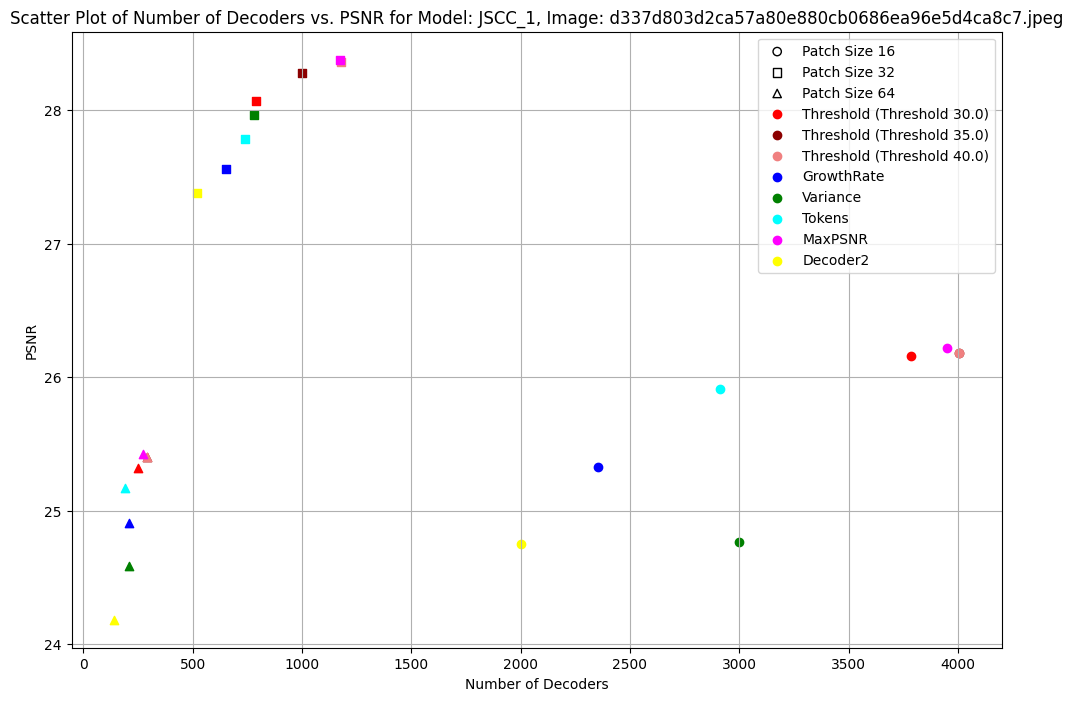

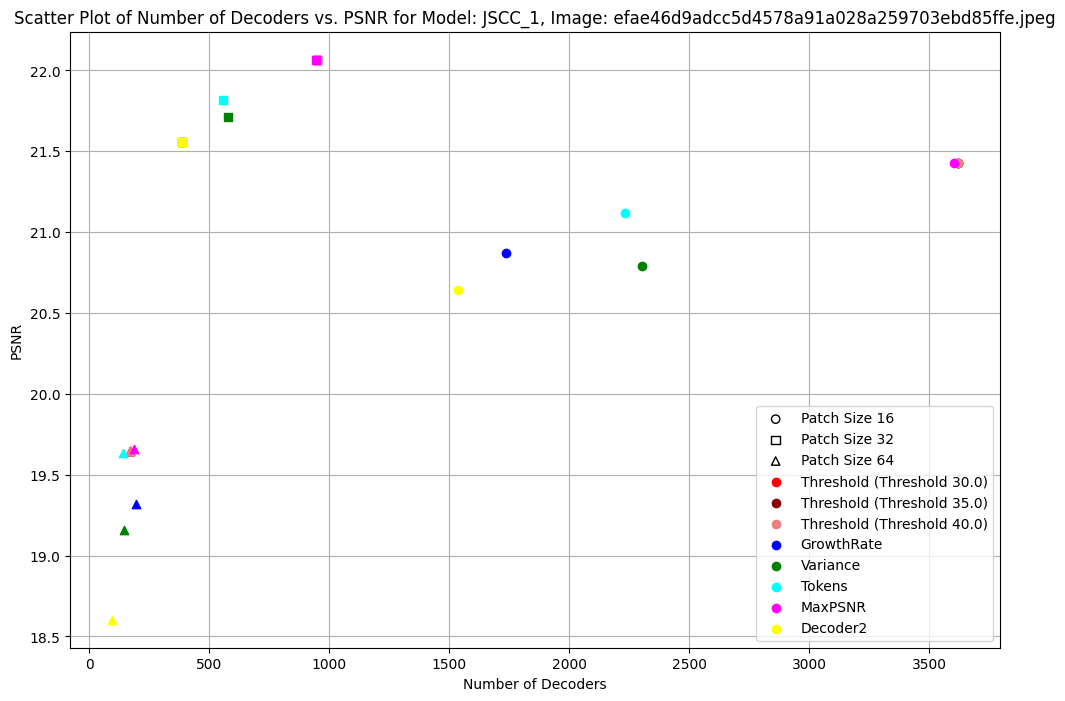

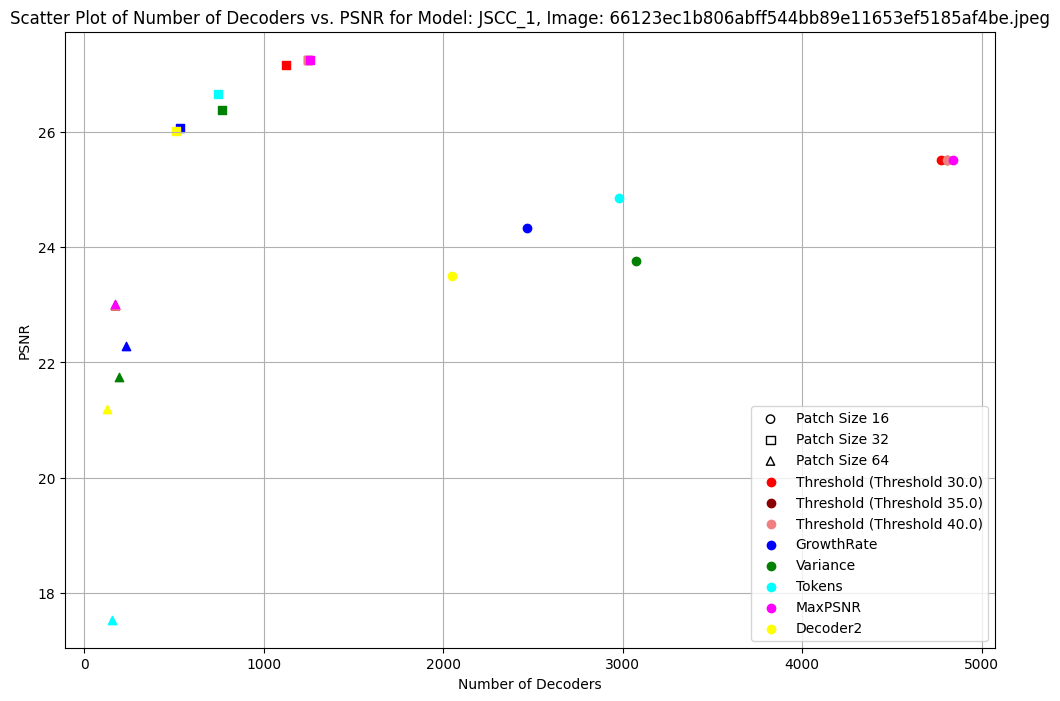

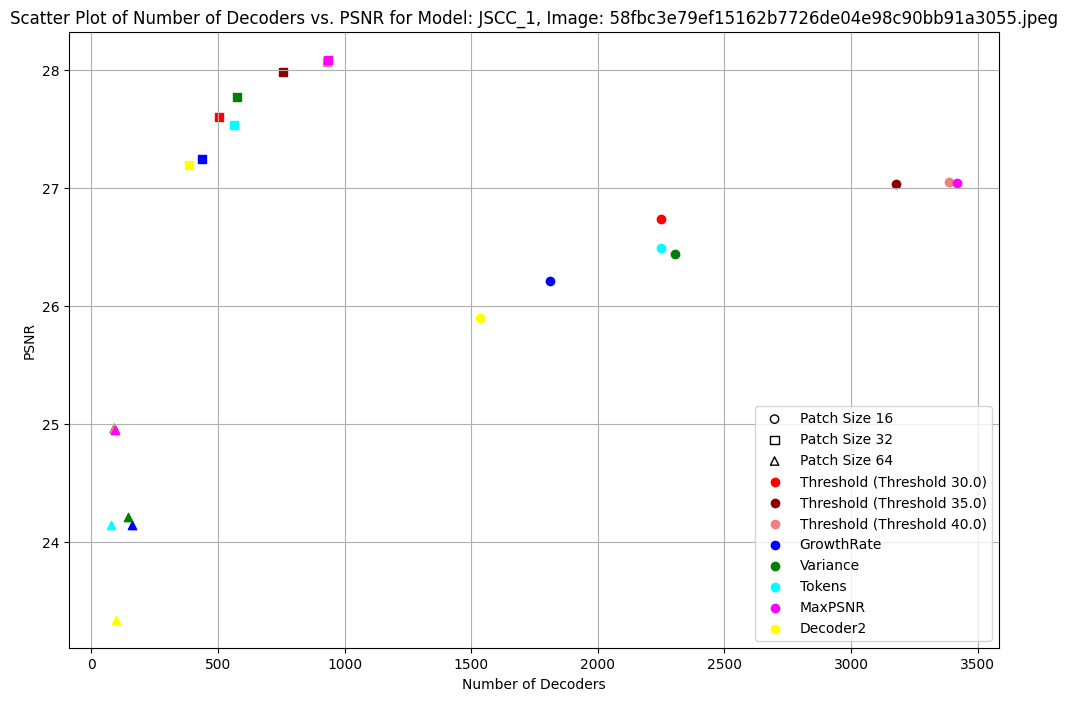

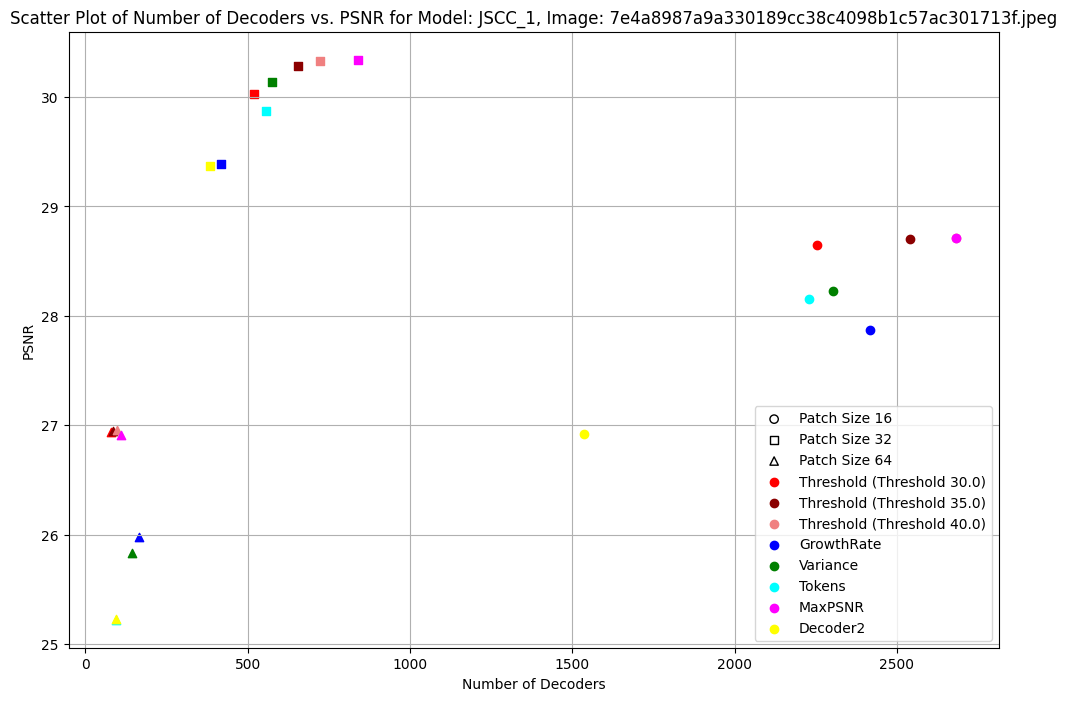

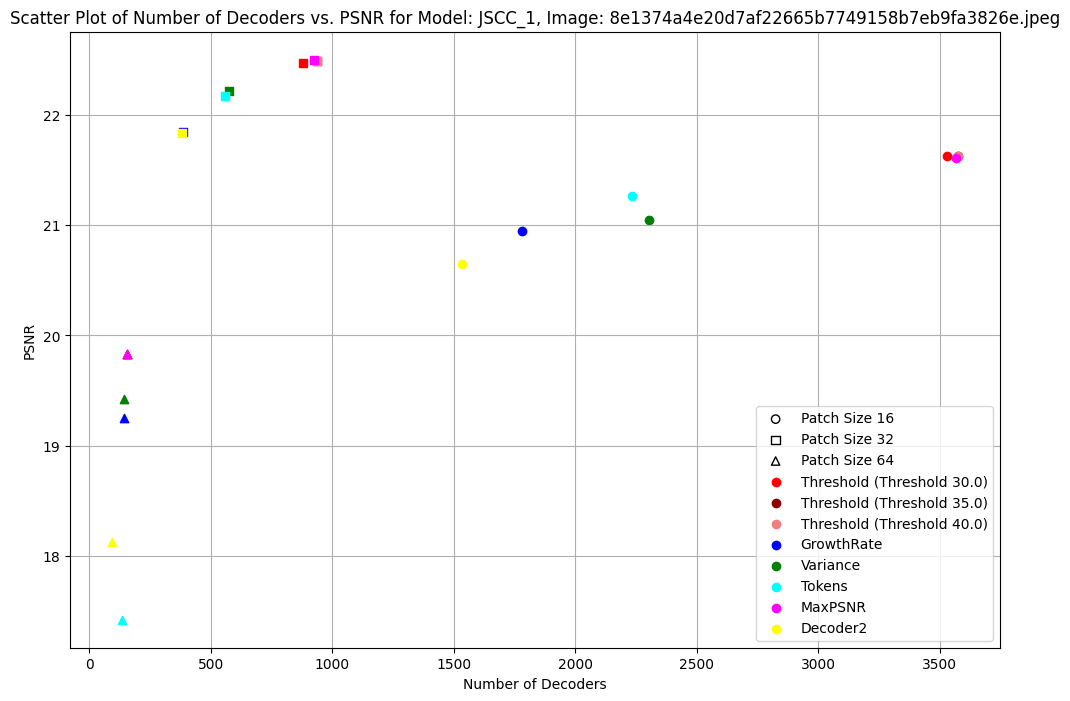

In [ ]:
# Define a color map for the methods
method_colors = {
    "GrowthRate": "blue",
    "Variance": "green",
    "Tokens": "cyan",
    "MaxPSNR": "magenta",
    "Decoder2": "yellow"
}

# Define colors for different thresholds within the Threshold method
threshold_colors = {
    30.0: "red",
    35.0: "darkred",
    40.0: "lightcoral"
}

# Define a marker map for patch sizes
patch_markers = {
    16: "o",  # Circle
    32: "s",  # Square
    64: "^"   # Triangle
}

# Creating scatter plots for each image and model
for image_id, results_list in results_by_image.items():
    # Segregate data by model
    data_by_model = {}
    for result in results_list:
        model = result['model']
        if model not in data_by_model:
            data_by_model[model] = {'num_decoders': [], 'psnr': [], 'method': [], 'patch_size': [], 'threshold': []}
        for key in result:
            if key != 'model':
                data_by_model[model][key].append(result[key])

    # Plot data for each model
    for model, data in data_by_model.items():
        plt.figure(figsize=(12, 8))
        used_labels = set()

        # Plot invisible points for legend for each patch size
        for patch_size, marker in patch_markers.items():
            plt.scatter([], [], marker=marker, color='none', edgecolor='black', label=f'Patch Size {patch_size}')

        # Plot actual data
        for i in range(len(data['num_decoders'])):
            method = data['method'][i]
            patch_size = data['patch_size'][i]
            threshold = data['threshold'][i]
            num_decoders = data['num_decoders'][i]
            psnr = data['psnr'][i]

            # Construct the label and color
            label = f"{method}"
            if method == "Threshold":
                color = threshold_colors.get(threshold, "black")
                label += f" (Threshold {threshold})"
            else:
                color = method_colors.get(method, "black")

            # Plotting with specific color and marker
            marker = patch_markers.get(patch_size, "o")
            if label not in used_labels:
                plt.scatter(num_decoders, psnr, label=label, color=color, marker=marker)
                used_labels.add(label)
            else:
                plt.scatter(num_decoders, psnr, color=color, marker=marker)

        plt.xlabel('Number of Decoders')
        plt.ylabel('PSNR')
        plt.title(f'Scatter Plot of Number of Decoders vs. PSNR for Model: {model}, Image: {image_id}')
        plt.legend()
        plt.grid()
        plt.show()

In [ ]:
# Initialize a dictionary to store PSNR values for each threshold method and other methods
psnr_values_by_method_and_threshold = {method: [] for method in methods}
psnr_values_by_method_and_threshold.update({f"Threshold_{threshold}": [] for threshold in psnr_thresholds})

# Iterate over each image and its results
for image_id, results_list in results_by_image.items():
    # Filter and collect PSNR values for patch size 32 for each method
    for result in results_list:
        if result['patch_size'] == 32:
            # Separate handling for Threshold method
            if result['method'] == 'Threshold':
                threshold_method = f"Threshold_{result['threshold']}"
                psnr_values_by_method_and_threshold[threshold_method].append(result['psnr'])
            else:
                psnr_values_by_method_and_threshold[result['method']].append(result['psnr'])

# Now calculate mean PSNR for each method and threshold
mean_psnr_by_method_and_threshold = {}
for method, psnr_values in psnr_values_by_method_and_threshold.items():
    if psnr_values:
        mean_psnr_by_method_and_threshold[method] = np.mean(psnr_values)
    else:
        mean_psnr_by_method_and_threshold[method] = None

mean_psnr_by_method_and_threshold

{'Threshold': None,
 'GrowthRate': 25.60899037554297,
 'Variance': 26.028538971559218,
 'Tokens': 25.971561651233404,
 'MaxPSNR': 26.43538688298825,
 'Decoder2': 25.55862124781636,
 'Threshold_30.0': 26.229462362564878,
 'Threshold_35.0': 26.3915005264253,
 'Threshold_40.0': 26.426649121091845}

In [ ]:
# Initialize a dictionary to store num_decoders values for each threshold method and other methods
num_decoders_by_method_and_threshold = {method: [] for method in methods}
num_decoders_by_method_and_threshold.update({f"Threshold_{threshold}": [] for threshold in psnr_thresholds})

# Iterate over each image and its results
for image_id, results_list in results_by_image.items():
    # Filter and collect num_decoders values for patch size 32 for each method
    for result in results_list:
        if result['patch_size'] == 32:
            # Separate handling for Threshold method
            if result['method'] == 'Threshold':
                threshold_method = f"Threshold_{result['threshold']}"
                num_decoders_by_method_and_threshold[threshold_method].append(result['num_decoders'])
            else:
                num_decoders_by_method_and_threshold[result['method']].append(result['num_decoders'])

# Now calculate mean num_decoders for each method and threshold
mean_num_decoders_by_method_and_threshold = {}
for method, num_decoders_list in num_decoders_by_method_and_threshold.items():
    if num_decoders_list:
        mean_num_decoders_by_method_and_threshold[method] = np.mean(num_decoders_list)
    else:
        mean_num_decoders_by_method_and_threshold[method] = None

mean_num_decoders_by_method_and_threshold

{'Threshold': None,
 'GrowthRate': 468.3333333333333,
 'Variance': 641.6666666666666,
 'Tokens': 619.6666666666666,
 'MaxPSNR': 1012.6666666666666,
 'Decoder2': 428.0,
 'Threshold_30.0': 794.6666666666666,
 'Threshold_35.0': 923.0,
 'Threshold_40.0': 993.3333333333334}